In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['JAX_ENABLE_X64'] = 'False'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import jax.experimental.sparse as jsparse
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter
import cloudpickle

from model import MessagePassing, FullyConnectedNet
from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.graph_utils import direc_graph_from_linear_system_sparse

from suite_sparse.naive_training import naive_train, dataset_subset_accum_grad
from suite_sparse.suitesparse_utils import KAPORIN_SUSBET, get_kaporin_subset, kapset_msize
from suite_sparse.suitesparse_utils import CorrectionNetKapSet

plt.rcParams['figure.figsize'] = (11, 7)

# Train/retrain/overwrite

In [3]:
save_path = '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/trained_models/'
model_name = 'div_k_grad_128_0.7_ilu0_llt_loss_1000epoch' # 'check_grad_accum_training'
load_model = True
train_model = True
save_model = False

# Setup experiment

In [4]:
mat_set_suitesparse = kapset_msize(1e5)[:8]  #KAPORIN_SUSBET
print(len(mat_set_suitesparse))
prec_type = 'load_pymatting'

8


In [5]:
with_cond = False
layer_ = Conv1d
alpha = jnp.array([0.])

2024-11-23 07:08:49.168727: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [23]:
batch_size = 2
epoch_num = 2
lr = 1e-3
schedule_params = None #[1700, 2001, 300, 1e-1]    # [start, stop, step, decay_size]

In [24]:
if schedule_params != None:
    assert len(schedule_params) == 4
    
    start, stop, step, decay_size = schedule_params
    steps_per_batch = N_train // batch_size
    start, stop, step = start*steps_per_batch, stop*steps_per_batch, step*steps_per_batch
    lr = optax.piecewise_constant_schedule(
        lr,
        {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
    )

In [6]:
model_config = {
    'node_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_dec': {
        'features': [16, 16, 1],
        'N_layers': 2,
        'layer_': layer_
    },
    'mp': {
        'edge_upd': {
            'features': [48, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'node_upd': {
            'features': [32, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'mp_rounds': 5
    }
}

# Make dataset

In [26]:
s1 = perf_counter()
A, A_pad, b, x = dataset_subset_accum_grad(mat_set=mat_set_suitesparse, prec_type=prec_type)

data_t = perf_counter() - s1
print(f"Data time: {data_t:.3f}")

Loading and decomposition: bodyy6, bcsstk18, bcsstk25, cvxbqp1, bcsstk17, gridgena, apache1, Pres_Poisson, 
  Loading is done
Data time: 0.785


In [27]:
A[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 134208 stored elements and shape (19366, 19366)>

In [28]:
A_pad[0]

BCOO(float32[19366, 19366], nse=97034)

In [29]:
A_pad[0].data.dtype

dtype('float32')

# Train model

In [7]:
seed = 42
NodeEncoder = FullyConnectedNet(**model_config['node_enc'], key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(**model_config['edge_enc'], key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(**model_config['edge_dec'], key=random.PRNGKey(seed))

MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(**model_config['mp']['edge_upd'], key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(**model_config['mp']['node_upd'], key=random.PRNGKey(seed)),
    mp_rounds=model_config['mp']['mp_rounds']
)

model = CorrectionNetKapSet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, alpha=alpha)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2754


In [31]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_pad, b, x],
    [A_pad, b, x]
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size,
}

In [32]:
if load_model:
    with open(save_path + model_name + '.pkl', 'rb') as f:
        model = cloudpickle.load(f)
        
if train_model:
    s = perf_counter()
    model, losses = naive_train(model, data, train_config, grad_accum_batch=True)
    dt = perf_counter() - s
    
else:
    losses, dt = [np.nan], np.nan
    
if save_model:
    with open(save_path + model_name + '.pkl', 'wb') as f:
        cloudpickle.dump(model, f)

Epoch 0
 Batch 0
 Batch 1
 Batch 2
 Batch 3
Epoch 1
 Batch 0
 Batch 1
 Batch 2
 Batch 3


[Array(nan, dtype=float32), Array(nan, dtype=float32)]


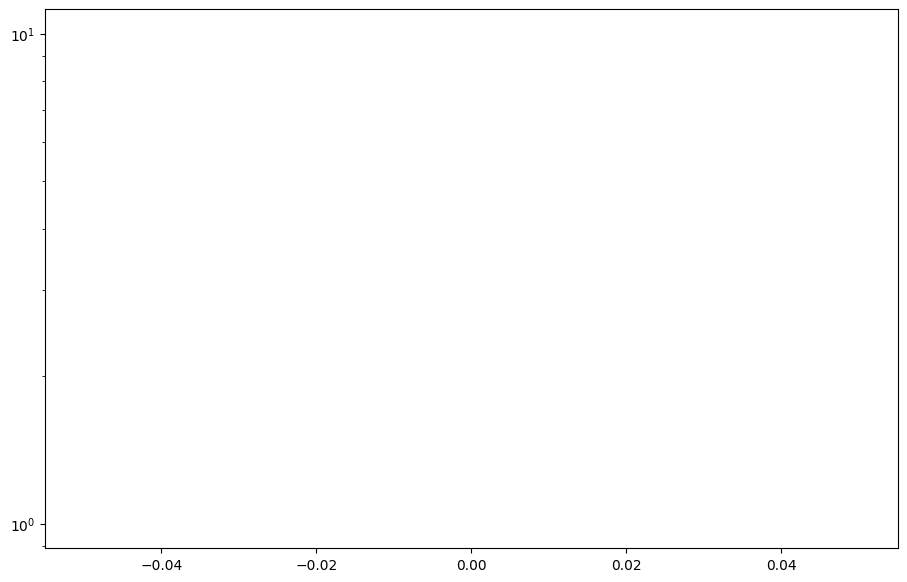

In [34]:
print(losses)
plt.plot(range(len(losses)), losses)
plt.yscale('log');

## Check loss

In [ ]:
# jnp.square(jnp.linalg.norm(L @ (L.T @ x) - b, ord=2))

In [ ]:
A_pad[0][None, ...]

In [ ]:
from data.graph_utils import graph_to_low_tri_mat_sparse, graph_tril

nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad[0][None, ...], b[0][None, ...])
nodes, edges, receivers, senders = graph_tril(nodes, edges[0, ...], receivers[0, ...], senders[0, ...])
low_tri = graph_to_low_tri_mat_sparse(nodes, edges, receivers, senders)

In [19]:
low_tri

BCOO(float32[19366, 19366], nse=76787)

In [29]:
from loss.llt_loss import llt_loss
llt_loss(low_tri, x[0], b[0])

Array(3.1366928e+08, dtype=float32)

In [30]:
def compute_loss(model, A_pad, b, x):
    nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad, b)
    print([arr.shape for arr in (nodes, edges, receivers, senders)])
    L = vmap(model, in_axes=(0), out_axes=(0))((nodes, edges, receivers, senders))
    print([arr.shape for arr in (L, x, b)])
    loss = vmap(llt_loss, in_axes=(0, 0, 0), out_axes=(0))(L, x, b)
    return L, loss[0, ...]

In [32]:
L, loss = compute_loss(model, A_pad[0][None, ...], b[0][None, ...], x[0][None, ...])
loss

[(1, 19366), (1, 134208), (1, 134208), (1, 134208)]
[(1, 19366, 19366), (1, 19366), (1, 19366)]


Array(nan, dtype=float32)

In [35]:
display(L)
llt_loss(L[0, ...], x[0], b[0])

BCOO(float32[1, 19366, 19366], nse=76787, n_batch=1)

Array(nan, dtype=float32)

In [36]:
from utils import jBCOO_to_scipyCSR

In [57]:
np.allclose(L_nn_dense, L_init_dense)

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [61]:
L_nn = jBCOO_to_scipyCSR(L[0, ...])
L_init = jBCOO_to_scipyCSR(low_tri)

L_nn_dense = L_nn.todense()
L_init_dense = L_init.todense()

b_ = np.asarray(b[0][None, ...])
x_ = np.asarray(x[0][None, ...])

In [70]:
np.sum(np.isnan(L_nn_dense).astype(np.int32))

7038

In [63]:
np.allclose(L_nn_dense, L_init_dense)

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

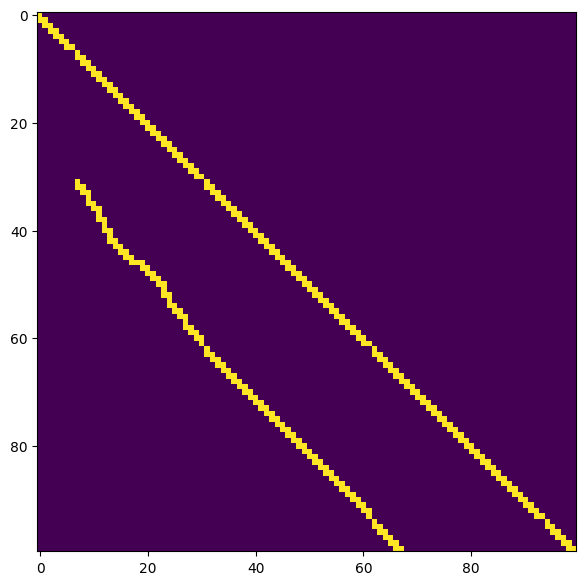

In [49]:
l = L_nn[500:600, 500:600]
l.data = l.data * 0 + 1
plt.imshow(l.todense())

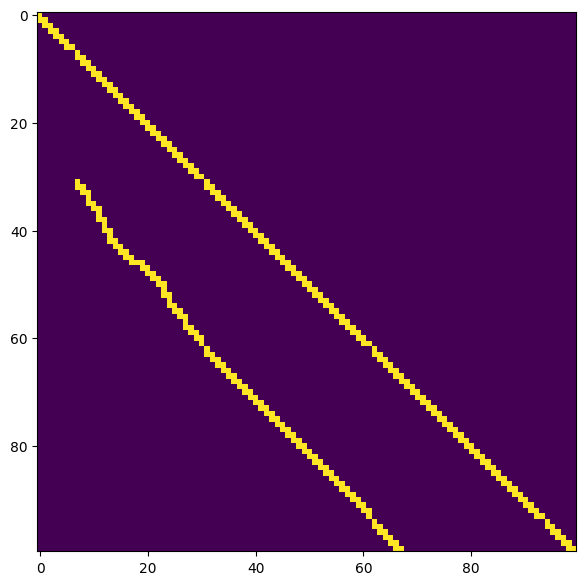

In [50]:
l = L_init[500:600, 500:600]
l.data = l.data * 0 + 1
plt.imshow(l.todense())

----

In [13]:
dt

22.566232109442353

In [27]:
print('alpha:', end='')
model.alpha

alpha:

Array([0.], dtype=float32)

TypeError: len() of unsized object

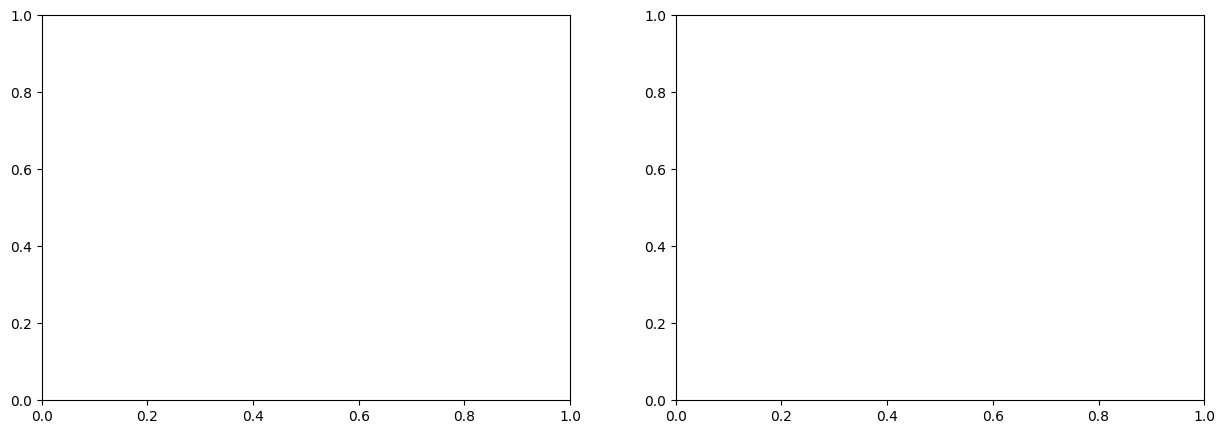

In [15]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

## Forward call time

In [16]:
from linsolve.scipy_linsolve import batched_cg_scipy, make_Chol_prec_from_bcoo, cg_scipy
from utils import jBCOO_to_scipyCSR

import scipy.sparse.linalg as sci_sp_linalg
import scipy.linalg as sci_linalg

In [20]:
b = vmap(jsparse.sparsify(lambda A_, x_: A_ @ x_), in_axes=(0, 0), out_axes=(0))(A_pad, jnp.ones(A_pad.shape[0:2])


(A_pad, jnp.ones(X[1]))
nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad, b)

L = vmap(model, in_axes=((0, 0, 0, 0)), out_axes=(0))((nodes, edges, receivers, senders))
# del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
# clear_caches()

In [21]:
P = make_Chol_prec_from_bcoo(L)
_, iters_mean, iters_std, time_mean, time_std = batched_cg_scipy(A_test, b_test, P=P, atol=1e-12, maxiter=N_valid_CG)

In [22]:
print('iters')
display(iters_mean)
iters_std

iters


[39.1, 51.085, 62.505, 73.85]

[1.104536101718726, 1.2719178432587537, 1.5264255632031325, 1.6393596310755]

Final values
  train loss: 398.0046
   test loss: 406.1051
    LLT cond: 1

Minimim test loss `394.2991` at epoch `994`

Minimim test P^(-1)A cond `1` at epoch `0`


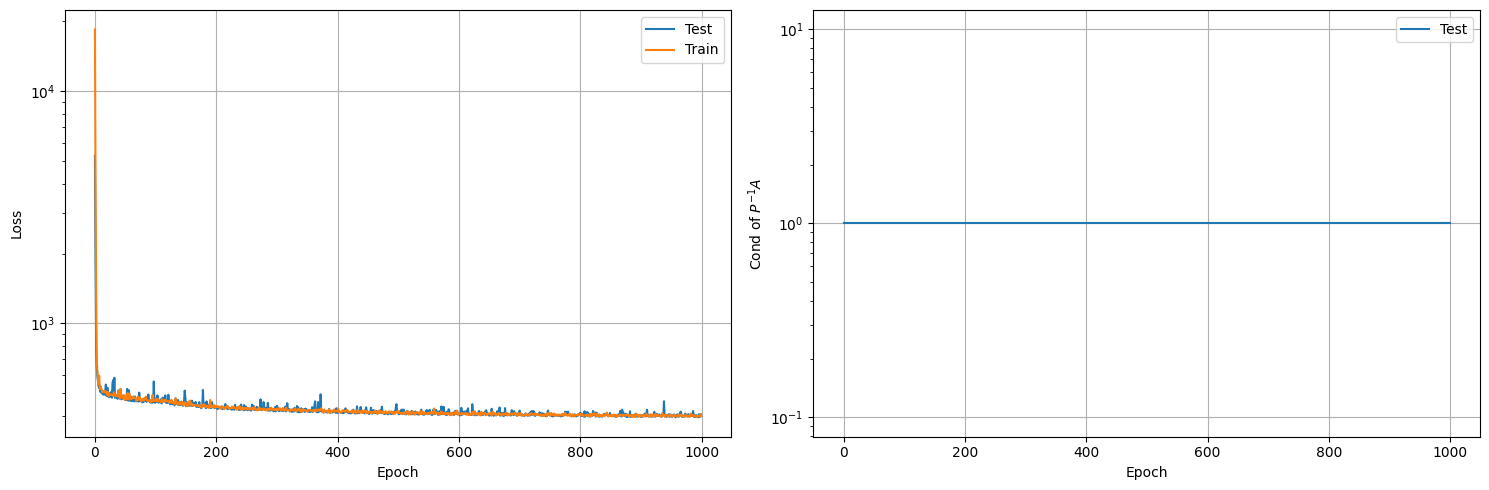

In [23]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

# Apply model to CG

In [22]:
from linsolve.scipy_linsolve import batched_cg_scipy, make_Chol_prec_from_bcoo, cg_scipy
from utils import jBCOO_to_scipyCSR

import scipy.sparse.linalg as sci_sp_linalg
import scipy.linalg as sci_linalg

In [23]:
P = make_Chol_prec_from_bcoo(L)

In [24]:
_, iters_mean, iters_std, time_mean, time_std = batched_cg_scipy(A_test, b_test, P=P, atol=1e-12, maxiter=N_valid_CG)

In [25]:
print('iters')
display(iters_mean)
iters_std

iters


[122.91, 155.29, 181.715, 204.38]

[4.95599636803741, 5.165839718767899, 5.301299369022655, 5.524092685681514]

In [26]:
print('time')
display(time_mean)
time_std

time


[0.27288701000623405,
 0.34374198608100415,
 0.4013962604943663,
 0.4508980005607009]

[0.01772112880748365,
 0.02130081274863664,
 0.023533461086636096,
 0.02582814137454491]

In [27]:
i = 0
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')
L_i = jBCOO_to_scipyCSR(L[i, ...])
P_i = (L_i @ L_i.T).todense(order='C')
print(' A, L and P are combined')

Pinv_i = sci_linalg.inv(P_i)
Ainv_i = sci_linalg.inv(A_i)
print(' A and P are inverted')

Pinv_A_i = Pinv_i @ A_i

eigen_i = np.abs(sci_linalg.eigvals(Pinv_A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')


P_Ainv_i = P_i @ Ainv_i
sqrt_loss = np.linalg.norm(P_Ainv_i - np.eye(P_i.shape[0]), ord='fro')
loss_i = np.square(sqrt_loss)
min_bound_i = 1 / (np.linalg.norm(P_Ainv_i, ord='fro'))
min_bound_long_i = 1 / (sqrt_loss + 1)
max_bound_i = np.linalg.norm(A_i - P_i, ord=2) * np.linalg.norm(Pinv_i, ord=2) + 1
print(' Norms are calculated')

# cond.append(cond_i)
# lambda_min.append(eigen_min_i)
# lambda_max.append(eigen_max_i)
# loss.append(loss_i)
# lambda_max_bound.append(max_bound_i)
# lambda_min_bound.append(min_bound_i)
# lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond_i:.5f}, lambda_min = {eigen_min_i:.5f}, lambda_max = {eigen_max_i:.5f}')
print(f'  loss = {loss_i:.5f}, lambda_max_bound = {max_bound_i:.5f}')
print(f'  lambda_min_bound = {min_bound_i:.5f}, lambda_min_long_bound = {min_bound_long_i:.5f}')

 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 570.76399, lambda_min = 0.00329, lambda_max = 1.88014
  loss = 312938.03237, lambda_max_bound = 91.80746
  lambda_min_bound = 0.00176, lambda_min_long_bound = 0.00178


In [28]:
eigen_i.sort()

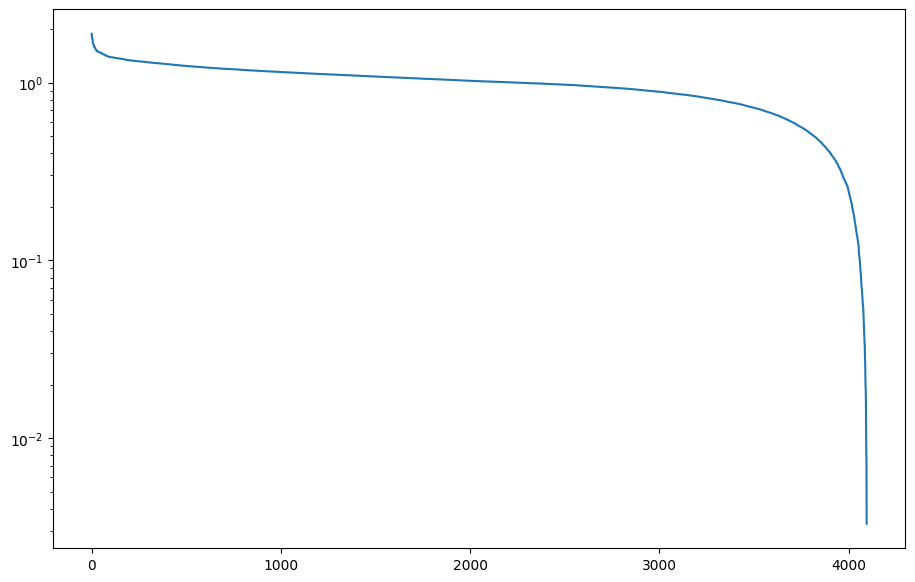

In [32]:
plt.semilogy(eigen_i[::-1])

In [33]:
np.savez('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/experiments/for_media_iclr/naive_loss_div_k_grad_64_0.7_ilu0___all_spectrum.npz', eigen_values=eigen_i)


# Spectrum w/ PreCorrecrtor

In [43]:
cond, lambda_min, lambda_max = [], [], []
loss, lambda_max_bound = [], []
lambda_min_bound, lambda_min_long_bound = [], []
i = 


# for i in range(1, A_test.shape[0]):
print(i)
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')
L_i = jBCOO_to_scipyCSR(L[i, ...])
P_i = (L_i @ L_i.T).todense(order='C')
print(' A, L and P are combined')

Pinv_i = sci_linalg.inv(P_i)
Ainv_i = sci_linalg.inv(A_i)
print(' A and P are inverted')

Pinv_A_i = Pinv_i @ A_i

eigen_i = np.abs(sci_linalg.eigvals(Pinv_A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')


P_Ainv_i = P_i @ Ainv_i
sqrt_loss = np.linalg.norm(P_Ainv_i - np.eye(P_i.shape[0]), ord='fro')
loss_i = np.square(sqrt_loss)
min_bound_i = 1 / (np.linalg.norm(P_Ainv_i, ord='fro'))
min_bound_long_i = 1 / (sqrt_loss + 1)
max_bound_i = np.linalg.norm(A_i - P_i, ord=2) * np.linalg.norm(Pinv_i, ord=2) + 1
print(' Norms are calculated')

cond.append(cond_i)
lambda_min.append(eigen_min_i)
lambda_max.append(eigen_max_i)
loss.append(loss_i)
lambda_max_bound.append(max_bound_i)
lambda_min_bound.append(min_bound_i)
lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond[-1]:.5f}, lambda_min = {lambda_min[-1]:.5f}, lambda_max = {lambda_max[-1]:.5f}')
print(f'  loss = {loss[-1]:.5f}, lambda_max_bound = {lambda_max_bound[-1]:.5f}')
print(f'  lambda_min_bound = {lambda_min_bound[-1]:.5f}, lambda_min_long_bound = {lambda_min_long_bound[-1]:.5f}')

1
 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 131.24338, lambda_min = 0.15369, lambda_max = 20.17122
  loss = 1706.49053, lambda_max_bound = 4402.34414
  lambda_min_bound = 0.00829, lambda_min_long_bound = 0.02364
2
 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 177.82838, lambda_min = 0.12098, lambda_max = 21.51283
  loss = 1761.81278, lambda_max_bound = 4289.11751
  lambda_min_bound = 0.00822, lambda_min_long_bound = 0.02327
3
 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 93.24665, lambda_min = 0.22720, lambda_max = 21.18580
  loss = 1755.87698, lambda_max_bound = 4426.08225
  lambda_min_bound = 0.00840, lambda_min_long_bound = 0.02331
4
 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 98.03062, lambda_min = 0.

KeyboardInterrupt: 

In [42]:
cond.append(cond_i)
lambda_min.append(eigen_min_i)
lambda_max.append(eigen_max_i)
loss.append(loss_i)
lambda_max_bound.append(max_bound_i)
lambda_min_bound.append(min_bound_i)
lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond[-1]:.5f}, lambda_min = {lambda_min[-1]:.5f}, lambda_max = {lambda_max[-1]:.5f}')
print(f'  loss = {loss[-1]:.5f}, lambda_max_bound = {lambda_max_bound[-1]:.5f}')
print(f'  lambda_min_bound = {lambda_min_bound[-1]:.5f}, lambda_min_long_bound = {lambda_min_long_bound[-1]:.5f}')

 All done
  cond = 78.03987, lambda_min = 0.19814, lambda_max = 15.46266
  loss = 1732.12761, lambda_max_bound = 4157.04033
  lambda_min_bound = 0.00838, lambda_min_long_bound = 0.02346


# Spectrum with NLA IC(0)

In [59]:
import ilupp

In [60]:
i = 0

In [61]:
L = ilupp.ichol0(jBCOO_to_scipyCSR(A_test[i, ...]))

In [62]:
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')
L_i = L
P_i = (L_i @ L_i.T).todense(order='C')
print(' A, L and P are combined')

Pinv_i = sci_linalg.inv(P_i)
Ainv_i = sci_linalg.inv(A_i)
print(' A and P are inverted')

Pinv_A_i = Pinv_i @ A_i

eigen_i = np.abs(sci_linalg.eigvals(Pinv_A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')


P_Ainv_i = P_i @ Ainv_i
sqrt_loss = np.linalg.norm(P_Ainv_i - np.eye(P_i.shape[0]), ord='fro')
loss_i = np.square(sqrt_loss)
min_bound_i = 1 / (np.linalg.norm(P_Ainv_i, ord='fro'))
min_bound_long_i = 1 / (sqrt_loss + 1)
max_bound_i = np.linalg.norm(A_i - P_i, ord=2) * np.linalg.norm(Pinv_i, ord=2) + 1
print(' Norms are calculated')

print(' All done')
print(f'  cond = {cond_i:.5f}, lambda_min = {eigen_min_i:.5f}, lambda_max = {eigen_max_i:.5f}')
print(f'  loss = {loss_i:.5f}, lambda_max_bound = {max_bound_i:.5f}')
print(f'  lambda_min_bound = {min_bound_i:.5f}, lambda_min_long_bound = {min_bound_long_i:.5f}')

 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated
 Norms are calculated
 All done
  cond = 200.80650, lambda_min = 0.00611, lambda_max = 1.22683
  loss = 79575.70741, lambda_max_bound = 62.25092
  lambda_min_bound = 0.00342, lambda_min_long_bound = 0.00353


In [63]:
np.savez('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/experiments/for_media_iclr/div_k_grad_64_0.7___ic0_spectrum.npz', eigen_values_ic0=eigen_i)

# Inital lhs

In [57]:
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')

eigen_i = np.abs(sci_linalg.eigvals(A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')
print(f'  cond = {cond_i:.5f}, lambda_min = {eigen_min_i:.5f}, lambda_max = {eigen_max_i:.5f}')

 Eigenvalues are calculated
  cond = 26808.89251, lambda_min = 18.96938, lambda_max = 508547.99942


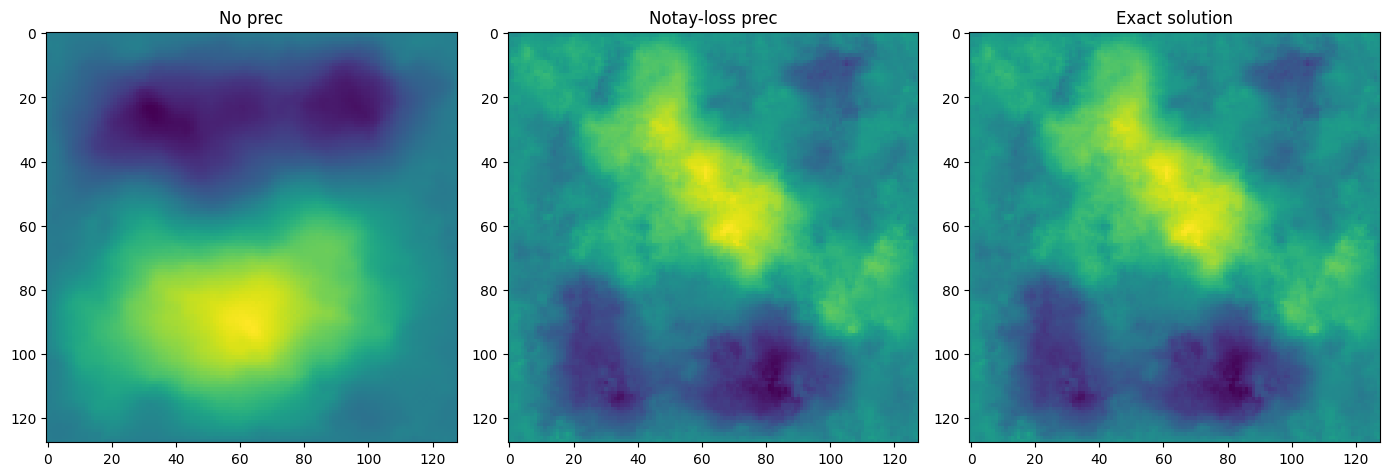

In [22]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()